In [1]:
import numpy as np
import matplotlib.pyplot as plt

import re
import sys
import torch

import datasets
import transformers

from datasets import load_dataset
from transformers import AutoTokenizer, EncoderDecoderModel

In [2]:
CACHE_DIR = "/media/dmitry/data/huggingface/cache_test"
MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [3]:
dataset = load_dataset('json', 
                       data_files='../../ria_news_dataset/ria.json.gz', 
                       split='train', 
                       cache_dir=CACHE_DIR)

Using custom data configuration default
Reusing dataset json (/media/dmitry/data/huggingface/cache_test/json/default-2ed633deaf6ae9cd/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514)


In [4]:
dataset

Dataset({
    features: ['text', 'title'],
    num_rows: 1003869
})

In [5]:
def clean_html_tags(s: str) -> str:
    s = re.sub('</?[\w\W]+?>', ' ', s)
    s = re.sub('\n|&nbsp;', ' ', s)
    s = re.sub('&(m|n)?dash;', ' – ', s)
    s = re.sub('&lt;', '<', s)
    s = re.sub('&gt;', '>', s)
    # s = re.sub(r"\'", "'", s)
    s = re.sub('&rsquo;', '’', s)
    s = re.sub('&hellip;', '…', s)
    s = re.sub('&amp;', '&', s)
    s = re.sub('\s\s+', ' ', s)
    return dict(text=s)


dataset = dataset.map(clean_html_tags, input_columns='text')

Loading cached processed dataset at /media/dmitry/data/huggingface/cache_test/json/default-2ed633deaf6ae9cd/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-ec432cb18499295c.arrow


In [6]:
split = dataset.train_test_split(test_size=100_000, shuffle=False)

split

Loading cached split indices for dataset at /media/dmitry/data/huggingface/cache_test/json/default-2ed633deaf6ae9cd/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-d2e124c2a34770fa.arrow and /media/dmitry/data/huggingface/cache_test/json/default-2ed633deaf6ae9cd/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-6f6752db9f66257a.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'title'],
        num_rows: 903869
    })
    test: Dataset({
        features: ['text', 'title'],
        num_rows: 100000
    })
})

In [7]:
train_data = split['train']
val_data = split['test']

In [8]:
dataset[:10]['title']

['большинство детей, которых пытались увезти в сша из гаити, не сироты',
 'луценко будет работать в команде тимошенко, если она победит в выборах',
 '"лютые" выборы: есть ли вероятность второго майдана?',
 'жертвами бойни на севере мексики стали 13 молодых людей, еще 20 ранены',
 'немец беррер выиграл теннисный турнир на родине         ',
 'переходное торговое соглашение сербии с ес вступает в силу 1 февраля',
 'генсек оон уверен в успехе мирных переговоров на кипре',
 '"байер" вернулся в лидеры чемпионата германии по футболу         ',
 'генсек оон прибыл на кипр, чтобы помочь мирным переговорам',
 'ликвидирован пожар в гаражном кооперативе на западе москвы']

In [9]:
train_data[:10]['title']

['большинство детей, которых пытались увезти в сша из гаити, не сироты',
 'луценко будет работать в команде тимошенко, если она победит в выборах',
 '"лютые" выборы: есть ли вероятность второго майдана?',
 'жертвами бойни на севере мексики стали 13 молодых людей, еще 20 ранены',
 'немец беррер выиграл теннисный турнир на родине         ',
 'переходное торговое соглашение сербии с ес вступает в силу 1 февраля',
 'генсек оон уверен в успехе мирных переговоров на кипре',
 '"байер" вернулся в лидеры чемпионата германии по футболу         ',
 'генсек оон прибыл на кипр, чтобы помочь мирным переговорам',
 'ликвидирован пожар в гаражном кооперативе на западе москвы']

In [10]:
dataset[-100_000:-99_990]['title']

['кабмин обсудит выделение крыму 895 млн руб на развитие "артека"',
 'королева из среднего класса: телеведущая вступает на испанский престол',
 'китайский миллиардер проведет благотворительный ужин в нью-йорке',
 'акустическую систему безопасности людей на ж/д готовят к испытаниям',
 'в обсе призвали участников женевских дискуссий к предметному диалогу',
 'депутатов рады на время заседаний оставят без еды, сообщают сми',
 'каждый день в мире появляются 130 новых миллионеров, пишут сми',
 'симоненко назвал фейком запись о якобы поставках кпу оружия ополченцам',
 'водоснабжение краматорска, дружковки и константиновки восстанавливают',
 'славянск парализован: в городе нет воды, электричества и медицины']

In [11]:
val_data[:10]['title']

['кабмин обсудит выделение крыму 895 млн руб на развитие "артека"',
 'королева из среднего класса: телеведущая вступает на испанский престол',
 'китайский миллиардер проведет благотворительный ужин в нью-йорке',
 'акустическую систему безопасности людей на ж/д готовят к испытаниям',
 'в обсе призвали участников женевских дискуссий к предметному диалогу',
 'депутатов рады на время заседаний оставят без еды, сообщают сми',
 'каждый день в мире появляются 130 новых миллионеров, пишут сми',
 'симоненко назвал фейком запись о якобы поставках кпу оружия ополченцам',
 'водоснабжение краматорска, дружковки и константиновки восстанавливают',
 'славянск парализован: в городе нет воды, электричества и медицины']

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

In [13]:
def create_preprocess_fn(tokenizer):
    def _preprocess_fn(batch):
        text_tokens = tokenizer(batch["text"], padding=False, truncation=False)
        title_tokens = tokenizer(batch["title"], padding=False, truncation=False)

        batch["text_tokens"] = text_tokens.input_ids
        batch["title_tokens"] = title_tokens.input_ids
        return batch

    return _preprocess_fn

In [14]:
train_data = train_data.map(
    create_preprocess_fn(tokenizer), 
    batched=True,
    remove_columns=["text", "title"]
)

In [15]:
def calc_len(row):
    return dict(
        text_tokens=len(row["text_tokens"]),
        title_tokens=len(row["title_tokens"]), 
    )

lengths = train_data.map(calc_len)

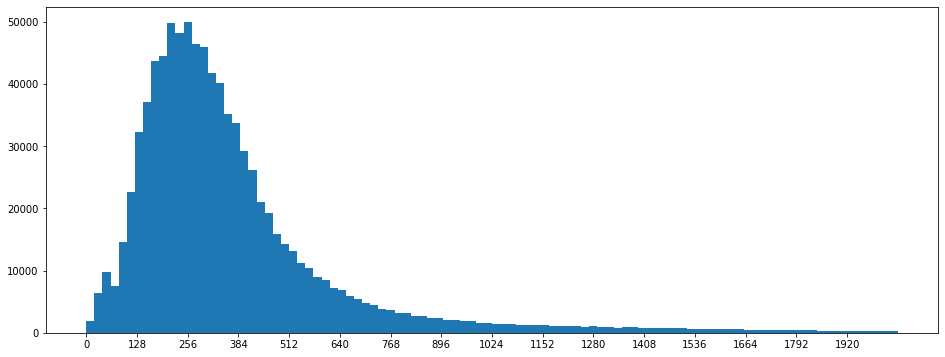

In [28]:
plt.figure(figsize=(16, 6))
plt.hist(lengths["text_tokens"],  bins=100, range=(0, 2048))
plt.xticks(range(0, 2048, 128))
plt.show()

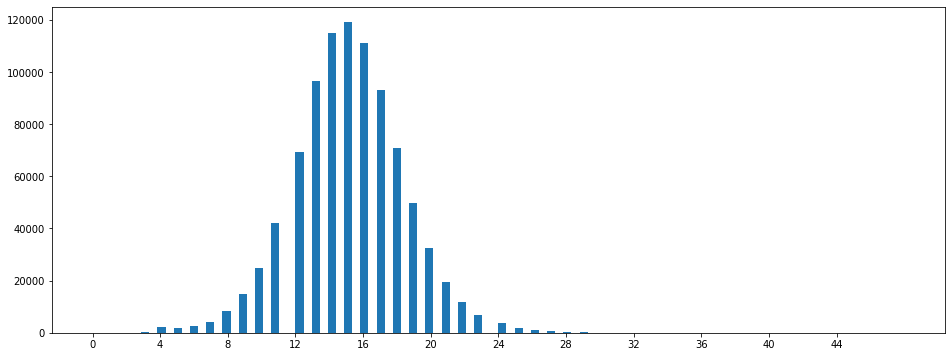

In [34]:
plt.figure(figsize=(16, 6))
plt.hist(lengths["title_tokens"],  bins=100, range=(0, 48))
plt.xticks(range(0, 48, 4))
plt.show()

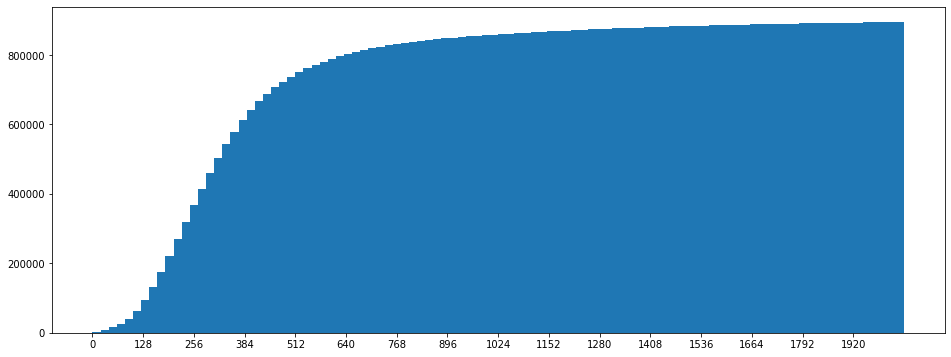

In [27]:
plt.figure(figsize=(16, 6))
plt.hist(lengths["text_tokens"],  bins=100, range=(0, 2048), cumulative=True)
plt.xticks(range(0, 2048, 128))
plt.show()

In [38]:
dataset[:3]['text']

[' москва, 31 янв - риа новости. большая часть из 33 детей, которых граждане сша пытались вывезти из гаити в организованный в доминиканской республике приют, не являются сиротами, сообщает в воскресенье агентство франс пресс со ссылкой на заявление представителя международной организации "детские деревни sos" (sos children\'s village), оказывающей помощь детям, оставшимся без родителей как заявила агентству патрисия варгас (patricia vargas), курирующая программы "детских деревень sos" в центральной америке, мексике и на карибах, поговорив с детьми она выяснила, что родители многих из них живы. некоторые дети смогли назвать свои домашние адреса и номера телефонов, что дает возможность связаться с их родителями. в это воскресенье гаитянская полиция задержала десятерых граждан сша , подозреваемых в попытке без разрешения вывезти более 30 детей в доминиканскую республику. представитель баптистской церкви в городе меридиан американского штата айдахо шон лэнкфорд (sean lankford) заявил, что 